In [ ]:
import yaml
import os


In [ ]:
from google.colab import userdata
import os

token = userdata.get('GITHUB_TOKEN')



In [ ]:
!git clone https://{token}@github.com/Daino666/Probe_detection.git


Cloning into 'Probe_detection'...
remote: Enumerating objects: 489, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 489 (delta 21), reused 6 (delta 4), pack-reused 462 (from 1)
Receiving objects: 100% (489/489), 88.12 MiB | 20.45 MiB/s, done.
Resolving deltas: 100% (237/237), done.


In [ ]:
!ls
!nvidia-smi

Probe_detection  sample_data
Sun Jan 18 20:51:14 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+------------------

In [ ]:
import xml.etree.ElementTree as ET
import os

def convert_xml_to_yolo(xml_folder, output_folder, img_width=640, img_height=640):
    os.makedirs(output_folder, exist_ok=True)

    for xml_file in os.listdir(xml_folder):
        if not xml_file.endswith('.xml'):
            continue

        tree = ET.parse(os.path.join(xml_folder, xml_file))
        root = tree.getroot()

        txt_file = xml_file.replace('.xml', '.txt')

        with open(os.path.join(output_folder, txt_file), 'w') as f:
            for obj in root.findall('object'):
                class_id = 0  # Single class (probe)
                bbox = obj.find('bndbox')
                xmin = int(bbox.find('xmin').text)
                ymin = int(bbox.find('ymin').text)
                xmax = int(bbox.find('xmax').text)
                ymax = int(bbox.find('ymax').text)

                # Convert to YOLO format (normalized center x, y, width, height)
                x_center = ((xmin + xmax) / 2) / img_width
                y_center = ((ymin + ymax) / 2) / img_height
                width = (xmax - xmin) / img_width
                height = (ymax - ymin) / img_height

                f.write(f"{class_id} {x_center} {y_center} {width} {height}\n")

# Usage
convert_xml_to_yolo('/content/Probe_detection/labels', '/content/Probe_detection/labels')

In [ ]:
!wget -O /content/train_val_split.py https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/utils/train_val_split.py

# TO DO: Improve robustness of train_val_split.py script so it can handle nested data folders, etc
!python train_val_split.py --datapath="/content/Probe_detection" --train_pct=0.9

--2026-01-18 20:51:30--  https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/utils/train_val_split.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3203 (3.1K) [text/plain]
Saving to: ‘/content/train_val_split.py’

/content/train_val_ 100%[===================>]   3.13K  --.-KB/s    in 0s      

2026-01-18 20:51:30 (36.8 MB/s) - ‘/content/train_val_split.py’ saved [3203/3203]

Created folder at /content/data/train/images.
Created folder at /content/data/train/labels.
Created folder at /content/data/validation/images.
Created folder at /content/data/validation/labels.
Number of image files: 214
Number of annotation files: 428
Images moving to train: 192
Images moving to validation: 22


In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 31.5 MB/s eta 0:00:00


In [ ]:
# Python function to automatically create data.yaml config file
# 1. Reads "classes.txt" file to get list of class names
# 2. Creates data dictionary with correct paths to folders, number of classes, and names of classes
# 3. Writes data in YAML format to data.yaml

import yaml
import os

def create_data_yaml(path_to_classes_txt, path_to_data_yaml):

  # Read class.txt to get class names
  if not os.path.exists(path_to_classes_txt):
    print(f'classes.txt file not found! Please create a classes.txt labelmap and move it to {path_to_classes_txt}')
    return
  with open(path_to_classes_txt, 'r') as f:
    classes = []
    for line in f.readlines():
      if len(line.strip()) == 0: continue
      classes.append(line.strip())
  number_of_classes = len(classes)

  # Create data dictionary
  data = {
      'path': '/content/data',
      'train': 'train/images',
      'val': 'validation/images',
      'nc': number_of_classes,
      'names': classes
  }

  # Write data to YAML file
  with open(path_to_data_yaml, 'w') as f:
    yaml.dump(data, f, sort_keys=False)
  print(f'Created config file at {path_to_data_yaml}')

  return

# Define path to classes.txt and run function
path_to_classes_txt = '/content/Probe_detection/classes.txt'
path_to_data_yaml = '/content/data.yaml'

create_data_yaml(path_to_classes_txt, path_to_data_yaml)

print('\nFile contents:\n')
!cat /content/data.yaml

Created config file at /content/data.yaml

File contents:

path: /content/data
train: train/images
val: validation/images
nc: 1
names:
- Probe


In [ ]:
!yolo detect train data=data.yaml model=yolov8s.pt epochs=100 \
  hsv_h=0.03 hsv_s=0.8 hsv_v=0.5 degrees=15 flipud=0.5 mosaic=1.0

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.4.6 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=15, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.03, hsv_s=0.8, hsv_v=0.5, imgsz=640, int8=False, iou=0.7, keras=False, kobj=

In [ ]:
!yolo detect train data=data.yaml model=yolov8s.pt epochs=100 \
  hsv_h=0.03 hsv_s=0.8 hsv_v=0.5 degrees=15 flipud=0.5 mosaic=1.0

Ultralytics 8.4.6 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=15, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.03, hsv_s=0.8, hsv_v=0.5, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrai

In [ ]:
!yolo detect predict model=runs/detect/train2/weights/best.pt source=data/validation/images save=True

Ultralytics 8.4.6 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 73 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs

image 1/22 /content/data/validation/images/capture_20260118_140703.png: 480x640 1 Probe, 50.3ms
image 2/22 /content/data/validation/images/capture_20260118_140707.png: 480x640 1 Probe, 12.9ms
image 3/22 /content/data/validation/images/capture_20260118_140711.png: 480x640 1 Probe, 12.8ms
image 4/22 /content/data/validation/images/capture_20260118_140854.png: 480x640 1 Probe, 12.8ms
image 5/22 /content/data/validation/images/capture_20260118_141008.png: 480x640 1 Probe, 12.8ms
image 6/22 /content/data/validation/images/capture_20260118_141103.png: 480x640 1 Probe, 12.8ms
image 7/22 /content/data/validation/images/capture_20260118_141535.png: 480x640 1 Probe, 12.8ms
image 8/22 /content/data/validation/images/capture_20260118_141632.png: 480x640 2 Probes, 12.8ms
image 9/22 /content/data/validation/images/capture_20260118_141735.

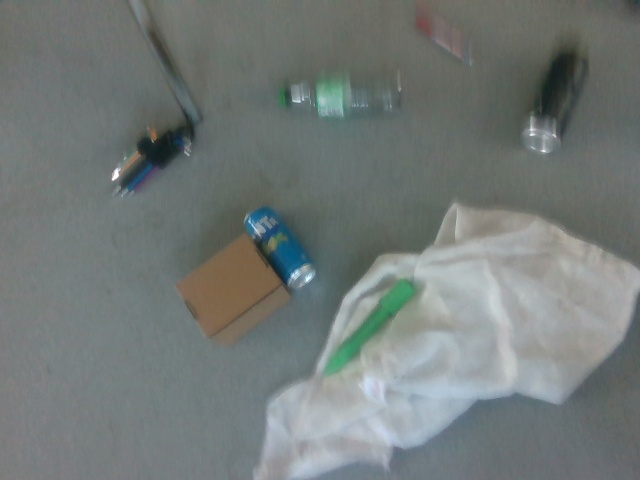

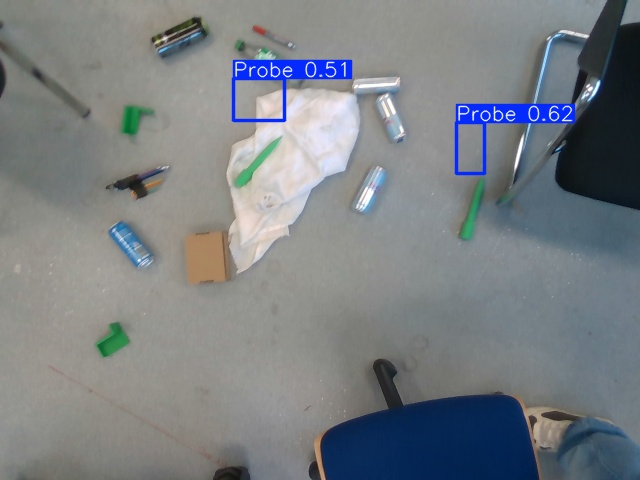

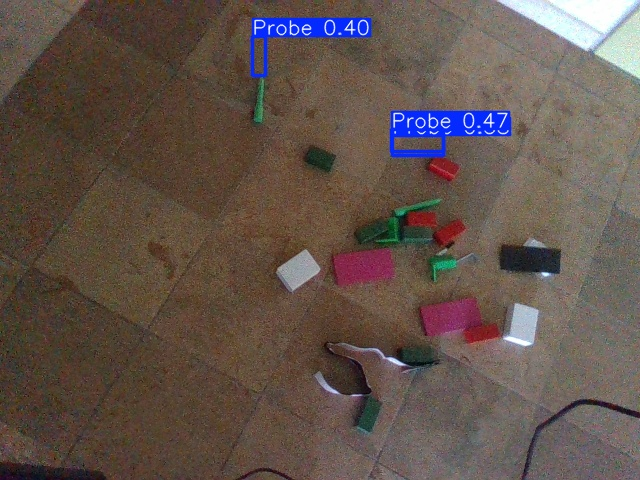

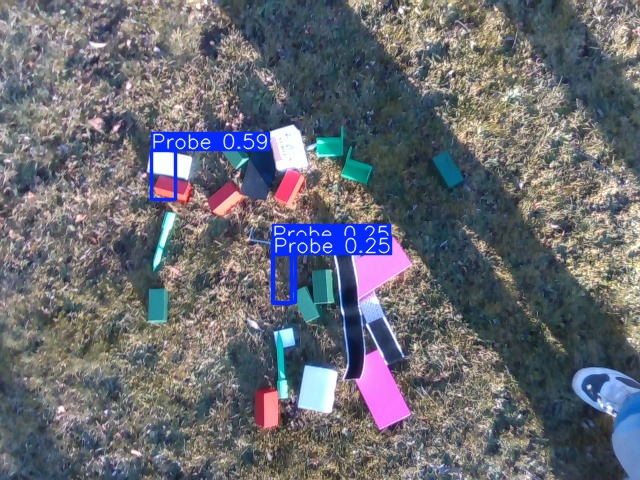

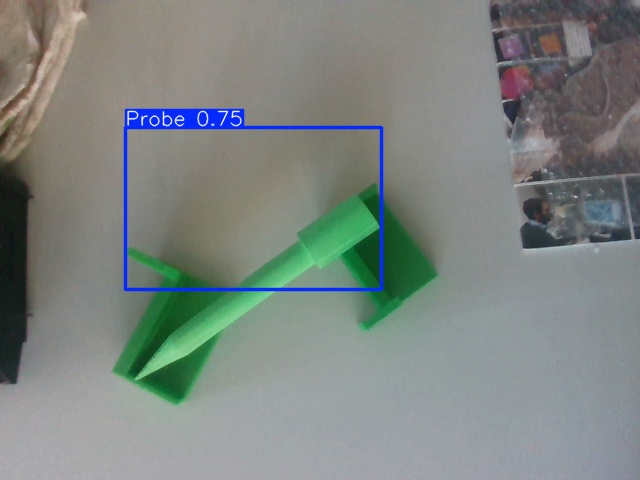

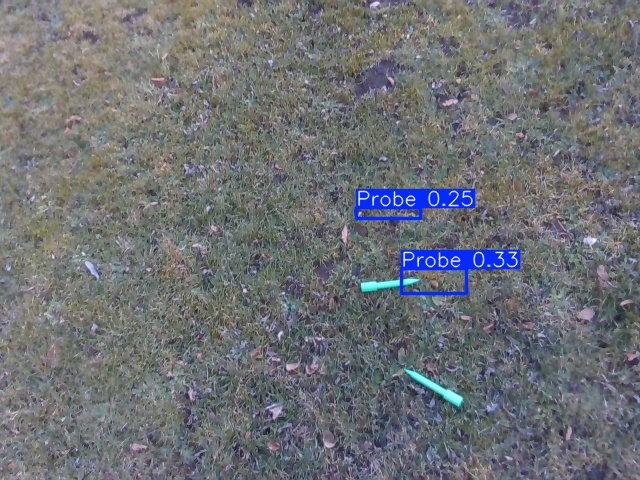

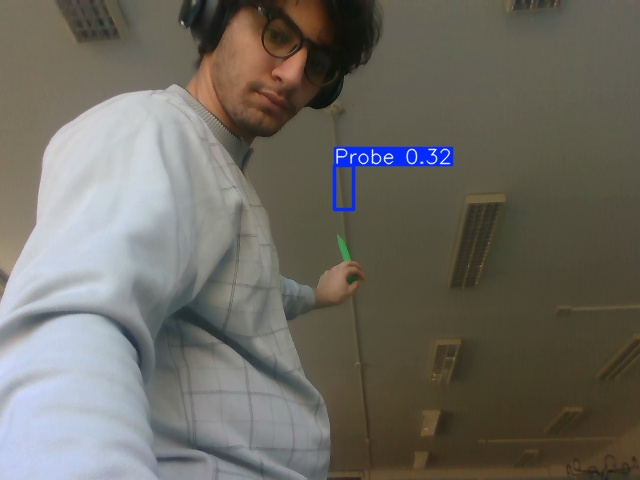

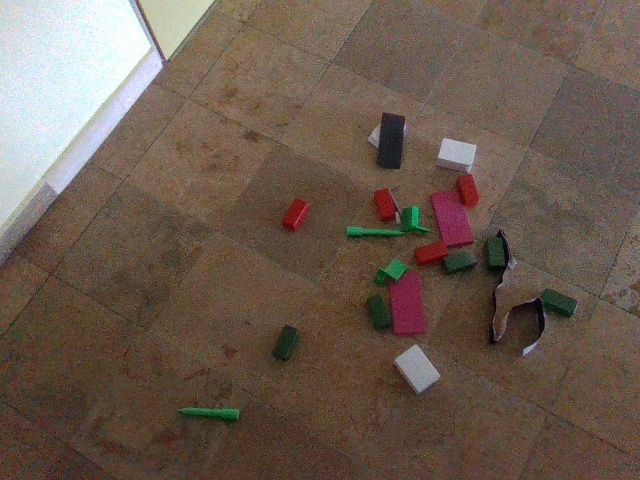

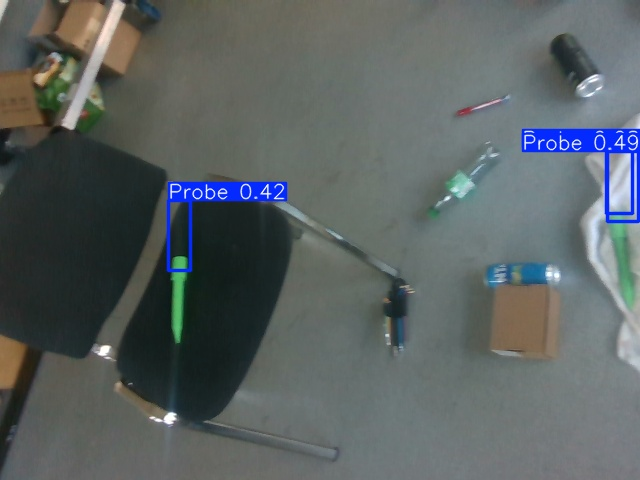

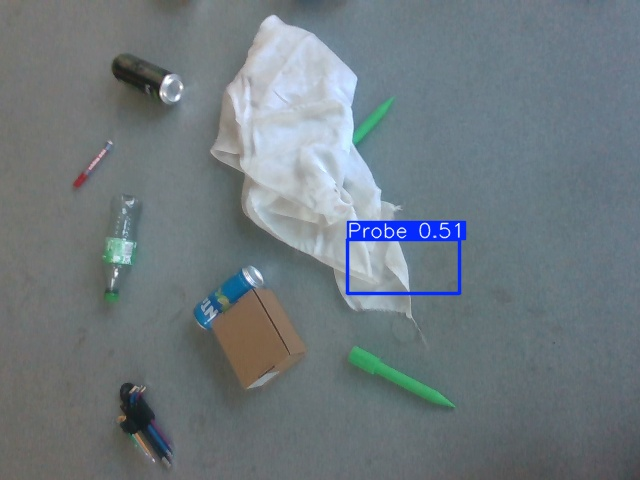

In [ ]:
import glob
from IPython.display import Image, display
for image_path in glob.glob(f'/content/runs/detect/predict/*.jpg')[:10]:
  display(Image(filename=image_path, height=400))
  print('\n')